In [62]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import qiime2 as q2
import numpy as np
%matplotlib inline

data_dir = 'data' #data from polybox (ASV, taxonomy analysis)
or_dir = '../data'
if not os.path.isdir(data_dir):
    os.mkdir(data_dir)

In [63]:
! wget -nv -O $data_dir/taxonomy_classification.qzv 'https://polybox.ethz.ch/index.php/s/c3rjz7z9GBUXvE8/download'
! wget -nv -O $data_dir/taxonomy_classification.qza 'https://polybox.ethz.ch/index.php/s/X8AoIryeOnLaCn5/download'
! wget -nv -O $data_dir/PJNB_dada2_table-filtered.qza 'https://polybox.ethz.ch/index.php/s/q2dsg2JxeJz3hko/download'
! wget -nv -O $data_dir/PJNB_dada2_rep_set-filtered.qza 'https://polybox.ethz.ch/index.php/s/vtDJzaCrmebL2u7/download'

2022-11-18 18:45:02 URL:https://polybox.ethz.ch/index.php/s/c3rjz7z9GBUXvE8/download [1967910/1967910] -> "data/taxonomy_classification.qzv" [1]
2022-11-18 18:45:02 URL:https://polybox.ethz.ch/index.php/s/X8AoIryeOnLaCn5/download [397957/397957] -> "data/taxonomy_classification.qza" [1]
2022-11-18 18:45:03 URL:https://polybox.ethz.ch/index.php/s/q2dsg2JxeJz3hko/download [1818719/1818719] -> "data/PJNB_dada2_table-filtered.qza" [1]
2022-11-18 18:45:03 URL:https://polybox.ethz.ch/index.php/s/vtDJzaCrmebL2u7/download [552613/552613] -> "data/PJNB_dada2_rep_set-filtered.qza" [1]


In [64]:
metadata = pd.read_csv(or_dir + '/metadata.tsv', sep = '\t')

In [65]:
print(metadata.shape, ' the number of samples we have and metadata variables that were collected')
print(metadata['host_id'].nunique(), ' unique hosts tracked over time') # number of hosts that were followed over time
print(metadata.columns)

(1669, 26)  the number of samples we have and metadata variables that were collected
80  unique hosts tracked over time
Index(['id', 'Library Layout', 'Instrument', 'collection_date',
       'geo_location_name', 'geo_latitude', 'geo_longitude', 'host_id',
       'age_days', 'weight_kg', 'length_cm', 'WAZ', 'HAZ', 'WHZ', 'BMI',
       'birth_weight_g', 'birth_length_cm', 'sex', 'delivery_mode', 'zygosity',
       'race', 'ethnicity', 'delivery_preterm', 'diet_milk', 'diet_weaning',
       'age_months'],
      dtype='object')


## Loading taxonomy assignments file
QUESTION: how to download csv from qiime 2 taxa barplot to wanted level and with metadata info. Now did manually from the output visualization. 

In [66]:
taxonomic_assignments = pd.read_csv(data_dir+'/taxonomic_assignments.csv', index_col = 0) # import metadata with taxonomic assignment dataframe
print(taxonomic_assignments.shape)
#print(taxonomic_assignments.head())
taxonomic_assignments = taxonomic_assignments[taxonomic_assignments['diet_milk'] != 'no milk']
# REMOVED no milk, not specified what they mean, are the babies ill so getting food via infuse
# or did the mother run out of milk, does this then mean the babies are on formula?
# or are they on solid food?
print(taxonomic_assignments['diet_weaning'].unique(), ' possible values of diet weaning')
print(taxonomic_assignments['diet_milk'].unique(), ' possible values of diet milk')
print(taxonomic_assignments.shape)

(1669, 364)
[nan True False]  possible values of diet weaning
[nan 'bd' 'fd']  possible values of diet milk
(1639, 364)


In [67]:
col_names = taxonomic_assignments.columns
col_names_species = col_names[0:-25] #remove metadata columns, get all species
#print(col_names_species)
print(len(col_names_species), 'total number of taxonomies, all levels')
col_names_species = [i for i in col_names_species if not i.endswith('__')] #remove taxonomies unclassfied until species
print(len(col_names_species), 'species were identified in total')
metadata_cols = col_names[-25:] #columns with metadata info
print(metadata_cols)

Index(['Library Layout', 'Instrument', 'collection_date', 'geo_location_name',
       'geo_latitude', 'geo_longitude', 'host_id', 'age_days', 'weight_kg',
       'length_cm', 'WAZ', 'HAZ', 'WHZ', 'BMI', 'birth_weight_g',
       'birth_length_cm', 'sex', 'delivery_mode', 'zygosity', 'race',
       'ethnicity', 'delivery_preterm', 'diet_milk', 'diet_weaning',
       'age_months'],
      dtype='object')
339 total number of taxonomies, all levels
140 species were identified in total
Index(['Library Layout', 'Instrument', 'collection_date', 'geo_location_name',
       'geo_latitude', 'geo_longitude', 'host_id', 'age_days', 'weight_kg',
       'length_cm', 'WAZ', 'HAZ', 'WHZ', 'BMI', 'birth_weight_g',
       'birth_length_cm', 'sex', 'delivery_mode', 'zygosity', 'race',
       'ethnicity', 'delivery_preterm', 'diet_milk', 'diet_weaning',
       'age_months'],
      dtype='object')


## Strings for diet, no Booleans, no NaN

In [68]:
taxonomic_assignments['diet_weaning'] = taxonomic_assignments['diet_weaning'].replace({True: 'weaning', False:'not weaning'})
taxonomic_assignments['diet_weaning'] = taxonomic_assignments['diet_weaning'].fillna('weaned')
taxonomic_assignments['diet_milk'] = taxonomic_assignments['diet_milk'].fillna('weaned')
print(taxonomic_assignments['diet_weaning'].unique())
print(taxonomic_assignments['diet_milk'].unique())

['weaned' 'weaning' 'not weaning']
['weaned' 'bd' 'fd']


## Questions about data
A. Do all hosts go through weaning? 
    
    A: Yes
    
B. How many hosts switch back and forth 1 or more times between weaning True/False or NaN?
    
    B: 61 for weaning, 51 for milk. 
    
C. What is the distribution of diets?

    A: See bar plot
D. Do they still mention the milk type while weaning?

In [69]:
###A.
host_numbers = taxonomic_assignments['host_id'].unique()
for host in host_numbers:
    df = taxonomic_assignments[taxonomic_assignments['host_id'] == host]
    if (df['diet_weaning'] == 'weaning').sum() == 0:
        print(host, 'did not wean')

In [70]:
###B.
a=0
def collapse_consec_values(series): # function to collapse consecutive identical values into 1 
    # e.g. ['not weaning', 'weaning', 'weaning', 'weaning', 'weaned', 'weaning']
    # into ['not weaning', 'weaning', 'weaned', 'weaning']
    series = list(series)
    new = []; new.append(series[0])
    indices = []; indices.append(0)
    for i in range(1, len(series)):
        if series[i] != series[i-1]:
            new.append(series[i])
            indices.append(i) # log index of first time you see a state or repeat a state
    return new, indices

def count_back_switches(collapsed, ind, series): # assume weaning False, True, NaN is normal order
    # baby goes from drinking milk, to switching to solid food, to eating only solid food
    # however sometimes there's trial and error so need can repeat states
    # find 1st occurrence of weaning False, then last of weaning True and NaN
    collapsed = np.array(collapsed)
    coll_un = np.unique(collapsed)
    for states in coll_un:
        if states == 'not weaning': weaning_false_ind = np.argwhere(collapsed == 'not weaning')[0][0]
        if states == 'weaning': 
            weaning_true_ind1 = np.argwhere(collapsed =='weaning')[-1][0]
            weaning_true_ind2 = np.argwhere(collapsed =='weaning')[0][0]
        if states == 'weaned': weaned_ind = np.argwhere(collapsed == 'weaned')[-1][0]
    if len(coll_un) == 3:
        return np.array([ ind[weaning_true_ind1] - ind[weaning_false_ind+1], ind[weaned_ind] - ind[weaning_true_ind2+1] ])
    # count the first repeats as repeats, count the last repeats as repeats
    if 'not weaning' not in coll_un:
        print('only weaning and weaned')
        return np.array([ ind[weaning_true_ind1], ind[weaned_ind] - ind[weaning_true_ind2+1] ])
    if 'weaned' not in coll_un:
        print('only not weaning and weaning')
        return np.array([ ind[weaning_true_ind1] - ind[weaning_false_ind+1], len(series) - ind[weaning_true_ind2 + 1] ])
    
def count_back_switches_milk(series): # assume weaning False, True, NaN is normal order
    # baby goes from drinking milk, to switching to solid food, to eating only solid food
    # however sometimes there's trial and error so need can repeat states
    # find 1st occurrence of weaning False, then last of weaning True and NaN
    series = series.replace({'fd':'milk','bd':'milk', 'weaned':'weaned'})
    collapsed, ind =  collapse_consec_values(series)
    if len(np.unique(np.array(collapsed))) < len(collapsed):
        collapsed = np.array(collapsed)
        coll_un = np.unique(collapsed)
        for states in coll_un:
            if states == 'milk': weaning_false_ind = np.argwhere(collapsed == 'milk')[0][0]
            if states == 'weaned': 
                weaned_ind1 = np.argwhere(collapsed == 'weaned')[-1][0]
                weaned_ind2 = np.argwhere(collapsed == 'weaned')[0][0]
        if len(coll_un) == 2:
            return np.array([ ind[weaned_ind1] - ind[weaning_false_ind+1], len(series) - ind[weaned_ind2+1] ])
    else: return np.array([0,0])

total_switch_weaning=0
number_switch_weaning=0
num_total_switch_weaning = np.array([0,0])
total_switch_milk=0 # fact that the host switched between modes at least once or not
number_switch_milk=0 # number of extra switches in each host, summed
num_total_switch_milk= np.array([0,0])

for host in host_numbers:
    df = taxonomic_assignments[taxonomic_assignments['host_id'] == host]
    ages = df['age_days']
    ages = ages.sort_values()
    df = df.loc[ages.index, ] # sort by age
    weanings, weanings_ind = collapse_consec_values(df['diet_weaning'])
    
    if weanings != ['not weaning', 'weaning', 'weaned']: #expected normal sequence
        # note that some babies have only some timepoints e.g. not weaning or ['weaning', 'weaned']
        print(weanings); print(host)
        b = 1
    
    try: # check if NaN is also used as entry before first occurrence of not weaning (weaning False)
        # luckily this is not the case
        if weanings.index('weaned') < weanings.index('not weaning'):
            print(weanings); print(host)
            print(' has NaN value before first occurrence of weaning False')
    except: pass
    
    if len(np.unique(np.array(weanings))) < len(weanings):
        total_switch_weaning = total_switch_weaning + 1
        number_switch_weaning = number_switch_weaning + len(weanings) - len(np.unique(np.array(weanings)))
        num_total_switch_weaning = num_total_switch_weaning + count_back_switches(weanings, weanings_ind, df['diet_weaning'])
        
    milk, milk_ind = collapse_consec_values(df['diet_milk'])
    if len(np.unique(np.array(milk))) < len(milk):
        print(milk)
        total_switch_milk = total_switch_milk + 1
        number_switch_milk = number_switch_milk+ len(milk) - len(np.unique(np.array(milk)))
        num_total_switch_milk = num_total_switch_milk + count_back_switches_milk(df['diet_milk'])
    #print(milk)
    
    if len(ages.unique()) < len(ages):
        print(host)
        a=a+1
print(a, ' repeat measurements for one age (days)')
print(total_switch_weaning, ' number of hosts that switch back and forth between weaning and/or not weaning and/or NaN')
print(total_switch_milk, ' number of hosts that switch back and forth between breast milk and/or formula and/or no milk and/or NaN')

print(number_switch_weaning, ' number of times a weaning mode is repeated after another (not taking into account consecutive instances, they count as one)')
print(number_switch_milk, ' number of times a milk feeding mode is repeated after another (not taking into account consecutive instances, they count as one)')

print(num_total_switch_weaning, ' number of times a weaning mode is repeated after another (taking into account consecutive instances)')
print(num_total_switch_milk, ' number of times a milk mode is repeated after another (taking into account consecutive instances)')



['weaning', 'weaned']
10.1
['not weaning', 'weaning', 'weaned', 'weaning', 'weaned']
14.1
['fd', 'weaned', 'fd', 'weaned']
['not weaning', 'weaning', 'weaned', 'weaning', 'weaned']
14.2
['fd', 'weaned', 'fd', 'weaned']
['not weaning', 'weaning', 'not weaning', 'weaning', 'weaned']
15.1
['not weaning', 'weaning', 'not weaning', 'weaning', 'weaned']
15.2
['not weaning', 'weaning', 'not weaning', 'weaning', 'weaned']
16.1
['not weaning', 'weaning', 'not weaning', 'weaning', 'weaned']
16.2
['not weaning', 'weaning', 'not weaning', 'weaning', 'weaned']
17.1
['not weaning', 'weaning', 'not weaning', 'weaning', 'weaned', 'weaning', 'weaned']
17.2
['bd', 'fd', 'weaned', 'fd', 'weaned']
['weaning', 'weaned']
19.1
['fd', 'bd', 'fd', 'bd', 'weaned']
['bd', 'fd', 'bd', 'fd', 'bd', 'fd', 'weaned']
['not weaning', 'weaning', 'weaned', 'weaning', 'weaned']
2.1
['bd', 'fd', 'weaned', 'fd', 'weaned']
['weaning', 'weaned', 'weaning']
11.1
only weaning and weaned
['fd', 'weaned', 'fd']
['weaning']
11.2
[

In [101]:
# DEBUGGING, DELETE WHEN DONE
series = df['diet_milk']
series = series.replace({'fd':'milk','bd':'milk', 'weaned':'weaned'})
collapsed, ind =  collapse_consec_values(series)
if len(np.unique(np.array(collapsed))) < len(collapsed):
    collapsed = np.array(collapsed)
    coll_un = np.unique(collapsed)
    for states in coll_un:
        if states == 'milk': weaning_false_ind = np.argwhere(collapsed == 'milk')[0][0]
        if states == 'weaned': 
            weaned_ind1 = np.argwhere(collapsed == 'weaned')[-1][0]
            weaned_ind2 = np.argwhere(collapsed == 'weaned')[0][0]
    if len(coll_un) == 2:
        a= np.array([ ind[weaned_ind1] - ind[weaning_false_ind+1], len(series) - ind[weaning_true_ind2+1] ])



<AxesSubplot:>

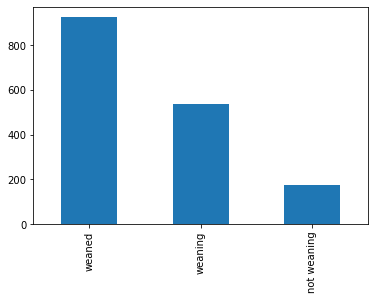

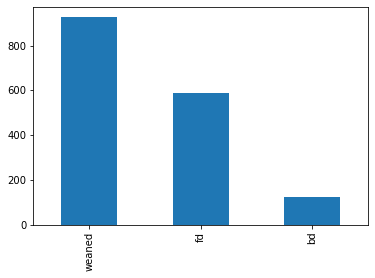

In [71]:
###C.
plt.figure()
taxonomic_assignments['diet_weaning'].value_counts().plot(kind='bar')
plt.figure()
taxonomic_assignments['diet_milk'].value_counts().plot(kind='bar')

## Decision tree classifier for milk diet and for weaning

In [72]:
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

def DTC(target, predictor):
    clf = DecisionTreeClassifier(random_state=42)#, max_depth = 50, min_samples_split = 0.01)
    #target = taxonomic_assignments['diet_milk'].fillna('weaned')
    cv_clf_milk = cross_val_score(clf, predictor, target, cv=5)
    print(sum(cv_clf_milk)/len(cv_clf_milk), ' percentage of classes that were correctly predicted in cross validation')
    cv_predict = cross_val_predict(clf, predictor, target, cv=5)
    class_report = classification_report(target, cv_predict, output_dict = True)
    print(classification_report(target, cv_predict, output_dict = False)) #, target_names=target_names))
    #print(class_report.index)
    conf_matrix = pd.DataFrame(confusion_matrix(target, cv_predict))
    conf_matrix.columns = list(class_report.keys())[0:-3]
    conf_matrix['index'] = list(class_report.keys())[0:-3]
    conf_matrix.set_index('index', inplace = True)
    print(conf_matrix)

In [73]:
DTC(taxonomic_assignments['diet_milk'].fillna('weaned'), taxonomic_assignments[col_names_species])
DTC(taxonomic_assignments['diet_weaning'], taxonomic_assignments[col_names_species])

0.7541116580890579
              precision    recall  f1-score   support

          bd       0.48      0.42      0.45       125
          fd       0.67      0.67      0.67       588
      weaned       0.83      0.86      0.84       926

    accuracy                           0.75      1639
   macro avg       0.66      0.65      0.65      1639
weighted avg       0.75      0.75      0.75      1639

        bd   fd  weaned
index                  
bd      52   63      10
fd      49  392     147
weaned   7  127     792
0.7284776609233982
              precision    recall  f1-score   support

 not weaning       0.52      0.49      0.50       175
      weaned       0.83      0.85      0.84       926
     weaning       0.61      0.60      0.60       538

    accuracy                           0.73      1639
   macro avg       0.65      0.64      0.65      1639
weighted avg       0.73      0.73      0.73      1639

             not weaning  weaned  weaning
index                                 

In [74]:
taxonomic_assignments[col_names_species].isnull().sum().sum()

0

## Random Forest Classifier

In [75]:
from sklearn.ensemble import RandomForestClassifier

def RFC(target, predictor):
    rfc = RandomForestClassifier(random_state=42)#, max_depth = 50, min_samples_split = 0.01)
    #target = taxonomic_assignments['diet_milk'].fillna('weaned')
    cv_rfc_milk = cross_val_score(rfc, predictor, target, cv=10)
    print(sum(cv_rfc_milk)/len(cv_rfc_milk))
    cv_predict = cross_val_predict(rfc, predictor, target, cv=5)
    class_report = classification_report(target, cv_predict, output_dict = True)
    print(classification_report(target, cv_predict, output_dict = False)) #, target_names=target_names))
    #print(class_report.index)
    conf_matrix = pd.DataFrame(confusion_matrix(target, cv_predict))
    conf_matrix.columns = list(class_report.keys())[0:-3]
    conf_matrix['index'] = list(class_report.keys())[0:-3]
    conf_matrix.set_index('index', inplace = True)
    print(conf_matrix)

In [76]:
RFC(taxonomic_assignments['diet_milk'].fillna('weaned'), taxonomic_assignments[col_names_species])
RFC(taxonomic_assignments['diet_weaning'], taxonomic_assignments[col_names_species])

0.8614918449797996
              precision    recall  f1-score   support

          bd       0.87      0.47      0.61       125
          fd       0.80      0.82      0.81       588
      weaned       0.89      0.94      0.91       926

    accuracy                           0.86      1639
   macro avg       0.85      0.74      0.78      1639
weighted avg       0.86      0.86      0.85      1639

        bd   fd  weaned
index                  
bd      59   63       3
fd       8  480     100
weaned   1   58     867
0.831587610354631
              precision    recall  f1-score   support

 not weaning       0.71      0.46      0.56       175
      weaned       0.89      0.94      0.92       926
     weaning       0.74      0.75      0.74       538

    accuracy                           0.83      1639
   macro avg       0.78      0.72      0.74      1639
weighted avg       0.82      0.83      0.82      1639

             not weaning  weaned  weaning
index                                  

## Ideas
* transform counts to fractions
* ASV instead of taxonomic assignment
* classifier: k-means, GMM (even though not Gaussian :/), Bayes, SVM
* Dimensionality reduction: either PCA or one of those or use decision tree to get most important features/species for this classification task
* try different taxonomic levels (now have only species)
* could select features with decision tree and then build NN classifier
* Which classes are being missclassified by these models?
* Could we infer response time to change in diet of microbiome from the relapsing into weaning/not weaning/weaned in the transition period?
* Build classifier for the zygosity: build one for the first 5 months, then 5-12 then 12 and more. 3 classes: mono, di, not related, make it balanced. If this classifier does well, then it means the genetics have an influence on the microbiome. Input: the taxonomic assignment/ASV of 2 babies. 

## Repeat analysis using fractions of abundance per species

In [77]:
taxonomic_assignments_frac = taxonomic_assignments[col_names_species].div(taxonomic_assignments[col_names_species].sum(axis=1), axis=0)

In [78]:
DTC(taxonomic_assignments['diet_milk'].fillna('weaned'), taxonomic_assignments_frac)
DTC(taxonomic_assignments['diet_weaning'], taxonomic_assignments_frac)

RFC(taxonomic_assignments['diet_milk'].fillna('weaned'), taxonomic_assignments_frac)
RFC(taxonomic_assignments['diet_weaning'], taxonomic_assignments_frac)

0.7455713433281123
              precision    recall  f1-score   support

          bd       0.58      0.48      0.53       125
          fd       0.65      0.69      0.67       588
      weaned       0.83      0.81      0.82       926

    accuracy                           0.75      1639
   macro avg       0.69      0.66      0.67      1639
weighted avg       0.75      0.75      0.75      1639

        bd   fd  weaned
index                  
bd      60   57       8
fd      33  408     147
weaned  10  162     754
0.7260218542552398
              precision    recall  f1-score   support

 not weaning       0.45      0.49      0.47       175
      weaned       0.84      0.86      0.85       926
     weaning       0.62      0.57      0.59       538

    accuracy                           0.73      1639
   macro avg       0.64      0.64      0.64      1639
weighted avg       0.72      0.73      0.72      1639

             not weaning  weaned  weaning
index                                 

In [19]:
taxonomic_assignments_frac

,k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Actinomycetales;f__Corynebacteriaceae;g__Corynebacterium;s__variabile,k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Lachnospiraceae;g__Ruminococcus;s__lactaris,k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Lachnospiraceae;g__[Ruminococcus];s__gnavus,k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Actinomycetales;f__Micrococcaceae;g__Rothia;s__mucilaginosa,k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Ruminococcaceae;g__Faecalibacterium;s__prausnitzii,k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Clostridiaceae;g__Clostridium;s__neonatale,k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Ruminococcaceae;g__Gemmiger;s__formicilis,k__Bacteria;p__Firmicutes;c__Bacilli;o__Bacillales;f__Paenibacillaceae;g__Paenibacillus;s__macerans,k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Ruminococcaceae;g__Clostridium;s__islandicum,k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Lachnospiraceae;g__Coprococcus;s__eutactus,...,k__Bacteria;p__Actinobacteria;c__Coriobacteriia;o__Coriobacteriales;f__Coriobacteriaceae;g__Atopobium;s__vaginae,k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Lachnospiraceae;g__Lachnoanaerobaculum;s__orale,k__Bacteria;p__Firmicutes;c__Erysipelotrichi;o__Erysipelotrichales;f__Erysipelotrichaceae;g__Anaerorhabdus;s__furcosa,k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Veillonellaceae;g__Selenomonas;s__noxia,k__Bacteria;p__Proteobacteria;c__Epsilonproteobacteria;o__Campylobacterales;f__Campylobacteraceae;g__Campylobacter;s__ureolyticus,k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Streptococcaceae;g__Streptococcus;s__agalactiae,k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Actinomycetales;f__Actinomycetaceae;g__Actinomyces;s__europaeus,k__Bacteria;p__Firmicutes;c__Erysipelotrichi;o__Erysipelotrichales;f__Erysipelotrichaceae;g__Bulleidia;s__moorei,k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Ruminococcaceae;g__Clostridium;s__methylpentosum,k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Clostridiaceae;g__Clostridium;s__septicum
index,,,,,,,,,,,,,,,,,,,,,
ERR1309715,0.0,0.006466,0.036298,0.000000,0.400862,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
ERR1309716,0.0,0.016798,0.456588,0.000000,0.197126,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
ERR1309717,0.0,0.000000,0.300750,0.000000,0.300500,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
ERR1309718,0.0,0.000000,0.198964,0.000000,0.389701,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
ERR1309719,0.0,0.005904,0.022502,0.000000,0.314025,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ERR1315696,0.0,0.000000,0.117509,0.000000,0.587740,0.000000,0.007834,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
ERR1315697,0.0,0.000000,0.185819,0.000326,0.000000,0.003097,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.002771,0.0,0.0,0.0
ERR1331873,0.0,0.000000,0.000000,0.000000,0.000000,0.034865,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0


## PCA + standardize

In [79]:
from sklearn.preprocessing import StandardScaler
taxonomic_assignments_normal = pd.DataFrame(StandardScaler().fit_transform(taxonomic_assignments[col_names_species]))
taxonomic_assignments_normal.columns = taxonomic_assignments[col_names_species].columns
taxonomic_assignments_normal.set_index(taxonomic_assignments[col_names_species].index, inplace = True)

In [80]:
DTC(taxonomic_assignments['diet_milk'].fillna('weaned'), taxonomic_assignments_normal)
DTC(taxonomic_assignments['diet_weaning'], taxonomic_assignments_normal)

RFC(taxonomic_assignments['diet_milk'].fillna('weaned'), taxonomic_assignments_normal)
RFC(taxonomic_assignments['diet_weaning'], taxonomic_assignments_normal)

0.7541116580890579
              precision    recall  f1-score   support

          bd       0.48      0.42      0.45       125
          fd       0.67      0.67      0.67       588
      weaned       0.83      0.86      0.84       926

    accuracy                           0.75      1639
   macro avg       0.66      0.65      0.65      1639
weighted avg       0.75      0.75      0.75      1639

        bd   fd  weaned
index                  
bd      52   63      10
fd      49  392     147
weaned   7  127     792
0.7284776609233982
              precision    recall  f1-score   support

 not weaning       0.52      0.49      0.50       175
      weaned       0.83      0.85      0.84       926
     weaning       0.61      0.60      0.60       538

    accuracy                           0.73      1639
   macro avg       0.65      0.64      0.65      1639
weighted avg       0.73      0.73      0.73      1639

             not weaning  weaned  weaning
index                                 

In [81]:
taxonomic_assignments_normal

,k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Actinomycetales;f__Corynebacteriaceae;g__Corynebacterium;s__variabile,k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Lachnospiraceae;g__Ruminococcus;s__lactaris,k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Lachnospiraceae;g__[Ruminococcus];s__gnavus,k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Actinomycetales;f__Micrococcaceae;g__Rothia;s__mucilaginosa,k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Ruminococcaceae;g__Faecalibacterium;s__prausnitzii,k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Clostridiaceae;g__Clostridium;s__neonatale,k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Ruminococcaceae;g__Gemmiger;s__formicilis,k__Bacteria;p__Firmicutes;c__Bacilli;o__Bacillales;f__Paenibacillaceae;g__Paenibacillus;s__macerans,k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Ruminococcaceae;g__Clostridium;s__islandicum,k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Lachnospiraceae;g__Coprococcus;s__eutactus,...,k__Bacteria;p__Actinobacteria;c__Coriobacteriia;o__Coriobacteriales;f__Coriobacteriaceae;g__Atopobium;s__vaginae,k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Lachnospiraceae;g__Lachnoanaerobaculum;s__orale,k__Bacteria;p__Firmicutes;c__Erysipelotrichi;o__Erysipelotrichales;f__Erysipelotrichaceae;g__Anaerorhabdus;s__furcosa,k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Veillonellaceae;g__Selenomonas;s__noxia,k__Bacteria;p__Proteobacteria;c__Epsilonproteobacteria;o__Campylobacterales;f__Campylobacteraceae;g__Campylobacter;s__ureolyticus,k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Streptococcaceae;g__Streptococcus;s__agalactiae,k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Actinomycetales;f__Actinomycetaceae;g__Actinomyces;s__europaeus,k__Bacteria;p__Firmicutes;c__Erysipelotrichi;o__Erysipelotrichales;f__Erysipelotrichaceae;g__Bulleidia;s__moorei,k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Ruminococcaceae;g__Clostridium;s__methylpentosum,k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Clostridiaceae;g__Clostridium;s__septicum
index,,,,,,,,,,,,,,,,,,,,,
ERR1309715,-0.145091,0.526431,-0.448163,-0.212903,1.421952,-0.199448,-0.318560,-0.077738,-0.025461,-0.155136,...,-0.024708,-0.05573,-0.045131,-0.024708,-0.033909,-0.044631,-0.071407,-0.087123,-0.065229,-0.064288
ERR1309716,-0.145091,0.902753,0.633828,-0.212903,-0.222877,-0.199448,-0.318560,-0.077738,-0.025461,-0.155136,...,-0.024708,-0.05573,-0.045131,-0.024708,-0.033909,-0.044631,-0.071407,-0.087123,-0.065229,-0.064288
ERR1309717,-0.145091,-0.298583,0.045328,-0.212903,-0.076384,-0.199448,-0.318560,-0.077738,-0.025461,-0.155136,...,-0.024708,-0.05573,-0.045131,-0.024708,-0.033909,-0.044631,-0.071407,-0.087123,-0.065229,-0.064288
ERR1309718,-0.145091,-0.298583,0.102893,-0.212903,0.794861,-0.199448,-0.318560,-0.077738,-0.025461,-0.155136,...,-0.024708,-0.05573,-0.045131,-0.024708,-0.033909,-0.044631,-0.071407,-0.087123,-0.065229,-0.064288
ERR1309719,-0.145091,0.468535,-0.514111,-0.212903,0.962556,-0.199448,-0.318560,-0.077738,-0.025461,-0.155136,...,-0.024708,-0.05573,-0.045131,-0.024708,-0.033909,-0.044631,-0.071407,-0.087123,-0.065229,-0.064288
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ERR1315695,-0.145091,-0.298583,-0.609679,-0.212903,0.531431,-0.199448,0.005315,-0.077738,-0.025461,-0.155136,...,-0.024708,-0.05573,-0.045131,-0.024708,-0.033909,-0.044631,-0.071407,-0.087123,-0.065229,-0.064288
ERR1315697,-0.145091,-0.298583,0.010118,0.386665,-0.848683,-0.136497,-0.318560,-0.077738,-0.025461,-0.155136,...,-0.024708,-0.05573,-0.045131,-0.024708,-0.033909,-0.044631,8.654957,-0.087123,-0.065229,-0.064288
ERR1331873,-0.145091,-0.298583,-0.627004,-0.212903,-0.848683,0.165006,-0.318560,-0.077738,-0.025461,-0.155136,...,-0.024708,-0.05573,-0.045131,-0.024708,-0.033909,-0.044631,-0.071407,-0.087123,-0.065229,-0.064288


In [82]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(taxonomic_assignments_normal)
principalComponents = pd.DataFrame(principalComponents)
principalComponents.set_index(taxonomic_assignments[col_names_species].index, inplace = True)

principalComponents_nonnormal = pca.fit_transform(taxonomic_assignments[col_names_species])
principalComponents_nonnormal = pd.DataFrame(principalComponents_nonnormal)
principalComponents_nonnormal.set_index(taxonomic_assignments[col_names_species].index, inplace = True)

principalComponents.describe()
principalComponents.head()

,0,1
index,,
ERR1309715,-0.709285,-0.045054
ERR1309716,-0.158249,-0.033732
ERR1309717,0.353645,-0.018364
ERR1309718,0.004427,0.035178
ERR1309719,-0.797107,0.082983


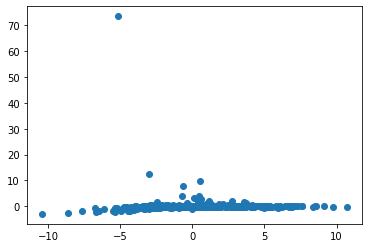

In [83]:
#plt.scatter(np.log(principalComponents.iloc[:,0]), np.log(principalComponents.iloc[:,1]))
plt.scatter(principalComponents.iloc[:,0], principalComponents.iloc[:,1])

{'weaning': 'red', 'not weaning': 'green', 'weaned': 'blue'}
weaning
1639
not weaning
1639
weaned
1639


(-5.0, 15.0)

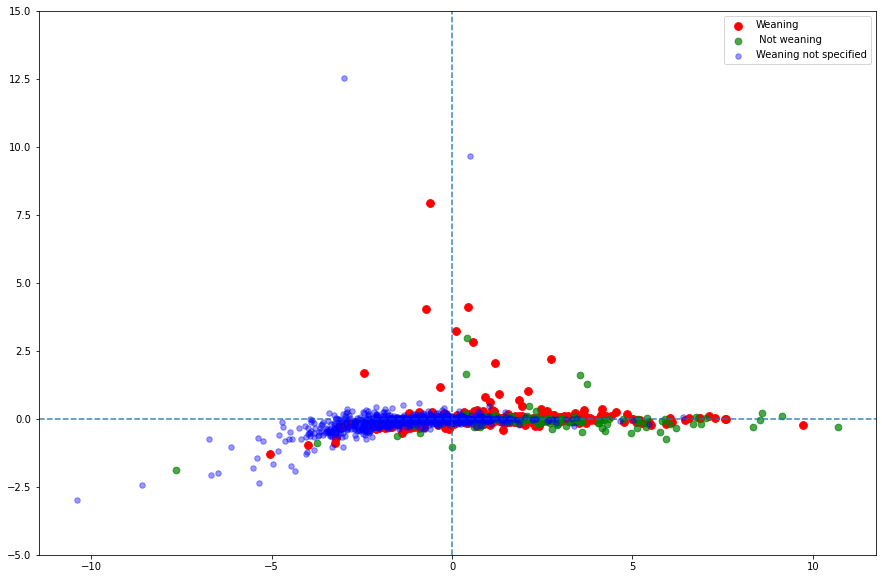

In [84]:
colours_weaning = {'weaning':'red', 'not weaning':'green', 'weaned':'blue'}#, 'other':'black'}
print(colours_weaning)
labels = ['Weaning', ' Not weaning', 'Weaning not specified']
fig, ax = plt.subplots(figsize = (15,10))
i=0
for key in colours_weaning:
    indices = (taxonomic_assignments['diet_weaning'] == key)
    print(key)
    print(len(indices))
    PCAs = principalComponents.loc[indices, ]
    ax.scatter(PCAs.iloc[:,0], PCAs.iloc[:,1], 
               color = colours_weaning[key], label = labels[i], s = 60-i*15,
               zorder = i, alpha = 1-i*0.3)
    ax.axhline(0, linestyle = '--', alpha = 0.4)
    ax.axvline(0, linestyle = '--', alpha = 0.4)
    i=i+1
ax.legend()
ax.set_ylim([-5, 15]) #one outlier at 70

(-5.0, 15.0)

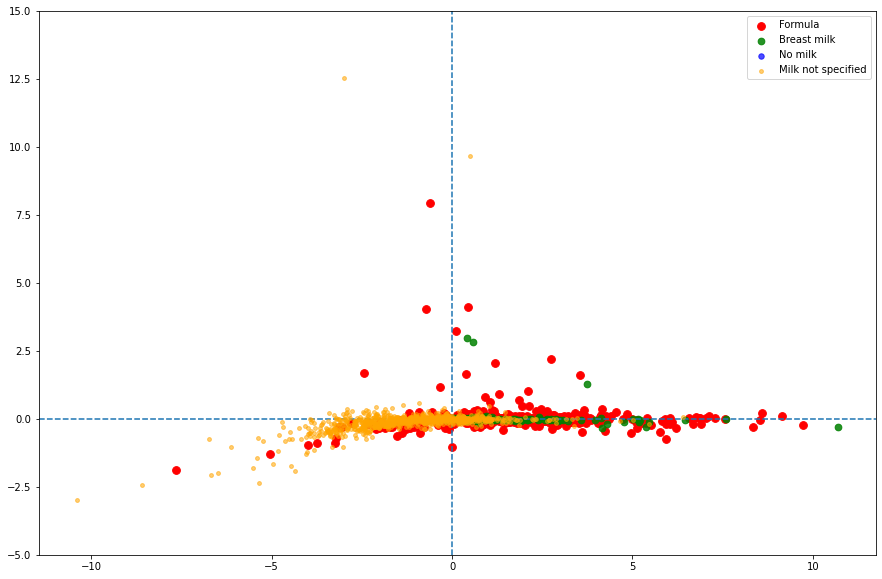

In [85]:
color_formula_breast = {'fd': 'red', 'bd': 'green', 'no milk': 'blue', 'weaned': 'orange'}
labels = ['Formula', 'Breast milk', 'No milk', 'Milk not specified']

fig, ax = plt.subplots(figsize = (15,10))
i=0
for key in color_formula_breast:
    indices = (taxonomic_assignments['diet_milk'] == key)
    PCAs = principalComponents.loc[indices, ]
    ax.scatter(PCAs.iloc[:,0], PCAs.iloc[:,1], 
               color = color_formula_breast[key], label = labels[i], s = 60-i*15,
                zorder = i, alpha = 1-i*0.15)
    ax.axhline(0, linestyle = '--', alpha = 0.4)
    ax.axvline(0, linestyle = '--', alpha = 0.4)
    i=i+1
ax.legend()
ax.set_ylim([-5, 15]) #one outlier at 70

In [86]:
(taxonomic_assignments['diet_weaning'] == key).sum()

926

# ASV

In [87]:
table_ASV = q2.Artifact.load(f'{data_dir}/PJNB_dada2_table-filtered.qza').view(pd.DataFrame)
#print(table_ASV.head())

In [88]:
table_ASV_metadata = pd.merge(table_ASV, taxonomic_assignments[metadata_cols], left_index=True, right_index=True)
#table_ASV.join(taxonomic_assignments[metadata_cols])
ASVs_cols = table_ASV_metadata.columns[0:-25]
print(ASVs_cols)

Index(['d7ccfef4d1779d9899c71c078d577f53', '09e9b81594db403cebe45252798e9f1a',
       'a25546433b23185d30d42c6f17919bf5', 'e4070f749d5a259df621f21c17e6e8c4',
       'ac4274f46d9ec670be0cfb4126304a8d', '33ba975cdb88b5073a2355ffdf01e9cb',
       'a55a010c9525ce2943a553dca1421b1c', '0ba92b5d91ba43524ebc6ea1ae7c5a73',
       '01b0120ab09ef9144d6328246c8974bf', '1edcadbfc3255ab508afd1e45dfba8d4',
       ...
       '19c1a28fee876dcaed48de3025a73f0f', '0dd18c01d94ab5dc26ceeff26bdb78e2',
       'fb5c2aa7e7a97d1ba29b2c9405cb6a41', '48a5435b473ab7675e51ece97e899ef5',
       'fec2da4ccc40b9ad85a020553063366b', '59de730fe3b76d4a99b96f2e3da59b34',
       'fa5266925cdc67882d4ad9095c624f17', 'aea35a6875f576f4eed0ff5352e108ae',
       'e94c3d2f198a7e3dee40f7d01d49fced', '384f1d7dbdd0280deb8931e3a88de8f9'],
      dtype='object', length=5072)


In [89]:
RFC(table_ASV_metadata['diet_milk'], table_ASV_metadata[ASVs_cols])
RFC(table_ASV_metadata['diet_weaning'], table_ASV_metadata[ASVs_cols])

0.865146640730211
              precision    recall  f1-score   support

          bd       0.87      0.43      0.58       125
          fd       0.81      0.84      0.82       588
      weaned       0.91      0.94      0.92       926

    accuracy                           0.87      1639
   macro avg       0.86      0.74      0.77      1639
weighted avg       0.87      0.87      0.86      1639

        bd   fd  weaned
index                  
bd      54   68       3
fd       7  493      88
weaned   1   51     874
0.8437902139757594
              precision    recall  f1-score   support

 not weaning       0.77      0.50      0.60       175
      weaned       0.91      0.94      0.92       926
     weaning       0.76      0.79      0.77       538

    accuracy                           0.85      1639
   macro avg       0.81      0.74      0.77      1639
weighted avg       0.84      0.85      0.84      1639

             not weaning  weaned  weaning
index                                  

In [90]:
print(table_ASV_metadata.shape)
print(table_ASV.shape)
print(taxonomic_assignments[metadata_cols].shape)

(1639, 5097)
(1669, 5072)
(1639, 25)


     id    name  s_id  marks
one   1   manoj     1     98
two   2  manoja     2     90


## More ideas
* PCA: remove outliers before doing PCA. How to find these outliers? E.g. the point with very high 2nd dimension in the plot. 
* Neural net with 2 inputs: the taxonomic assignment vector for 2 babies. Output: monozygotic, dizygotic, unrelated. 

## Zigosity classifier